In [1]:
# Regression example-1 for ENGR400
# Prepared by Dr. Raju Gottumukkala

import pandas as pd # Python module to work with tabular data
import numpy as np # Python module which supports MATLAB like matrix operation
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso # Linear Regression, Stocastic Gradient Decent
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error # Python modules to calculate different error metrics
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from matplotlib import pyplot as plt # Python plotting functions
import seaborn as sns # Special purpose plotting function
import statistics

In [2]:
import sklearn

In [3]:
#set plotting format to be used later
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D 
import matplotlib as mpl

%matplotlib inline 
mpl.rcParams['font.size']=10
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=5
mpl.rcParams['axes.titlesize']=10
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('whitegrid')
sns.set_context("poster", font_scale=0.5)

In [4]:
# These are subfunctions to calculate rolling average of mean and standard deviation for  window length 'w'
#df is the data frame, col is the feature, and w is the window length
def rollm(df, w, col):
    return df[col].rolling(w).mean().shift(1)

def rolls(df, w, col):
    return df[col].rolling(w).std().shift(1)

In [5]:
#STEP 0a: Read data
# Here we are reading data and asking python to index the column as a date
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

# df = pd.read_csv('TSLA.csv',index_col=0,parse_dates=["Date"])

# #print(df.to_string())
# print(df.head())

import yfinance as yf
df = yf.download('TSLA', '2014-06-01', '2017-09-17')

[*********************100%***********************]  1 of 1 completed


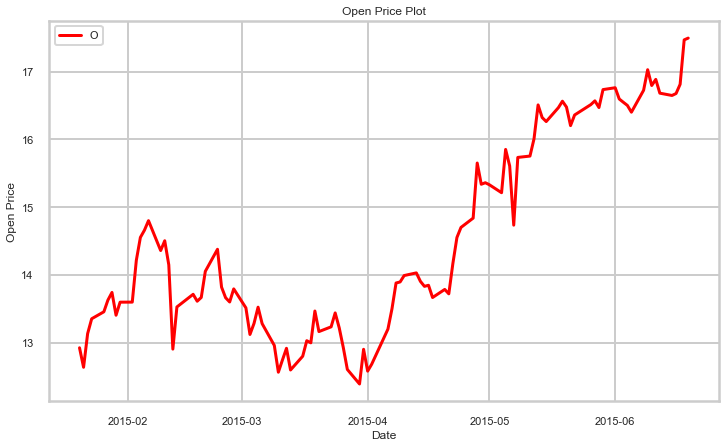

In [6]:
# STEP 0b: Understand data

# Note that the time series is between a certain range
# the df.loc allows you to select a range of data

df2 =df.loc["2015-1-20":"2015-6-21"]

# plot
plt.plot(df2.index,df2.Open, color='red')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Open Price Plot')
plt.legend("Open")
plt.show()
#plt.plot(df2)


In [7]:
# step1: Data pre-processing
data = df.dropna(axis=0)
df.size

4986

In [148]:
# step 2a: Feature extraction/computation

#data = generate_new_features(df)
 # We will store the new features in this dataframe

df_new = pd.DataFrame()
df_new['open'] = df['Open']

# Previous day variables (note the shift operator)
df_new['open_1'] = df['Open'].shift(1)
df_new['close_1'] = df['Close'].shift(1)
df_new['high_1'] = df['High'].shift(1)
df_new['low_1'] = df['Low'].shift(1)
df_new['volume_1'] = df['Volume'].shift(1)

# # average price
df_new['avg_price_5'] = rollm(df, 5, 'Close')
df_new['avg_price_30'] = rollm(df, 21, 'Close') 
df_new['avg_price_365'] = rollm(df, 252, 'Close')
df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']

# # average volume
df_new['avg_volume_5'] = rollm(df, 5, 'Volume')
df_new['avg_volume_30'] = rollm(df, 21, 'Volume')
df_new['avg_volume_365'] = rollm(df, 252, 'Volume') 
df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']

# # standard deviation of prices
df_new['std_price_5'] = rolls(df, 5, 'Close')
df_new['std_price_30'] = rolls(df, 21, 'Close')
df_new['std_price_365'] = rolls(df, 252, 'Close')
df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']

# # standard deviation of volumes
df_new['std_volume_5'] = rolls(df, 5, 'Volume')
df_new['std_volume_30'] = rolls(df, 21, 'Volume')
df_new['std_volume_365'] = rolls(df, 252, 'Volume')
df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']
df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']

# # return
df_new['return_1'] = ((df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)).shift(1)
df_new['return_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)).shift(1)
df_new['return_30'] = ((df['Close'] - df['Close'].shift(21)) / df['Close'].shift(21)).shift(1)
df_new['return_365'] = ((df['Close'] - df['Close'].shift(252)) / df['Close'].shift(252)).shift(1)
df_new['moving_avg_5'] = rollm(df_new, 5, 'return_1')
df_new['moving_avg_30'] = rollm(df_new, 21, 'return_1') 
df_new['moving_avg_365'] = rollm(df_new, 252, 'return_1')

# the goal is to predict the target variable

# CHANGE TO OPEN PRICE OF THE NEXT DAY , USE SHIFT(-1) TO LOOK AHEAD ------------------------------------
df_new['open_nd'] = df['Open'].shift(-1)

In [139]:
# Note that we will have some null values and nan, we have to clearn them

#check how many nan values
df_new.isnull().sum().sum()

#drop all the naans and round data to 3 digits
data = df_new.dropna(axis=0)
data = df_new.round(decimals=3)

#data has all of our features in it, col 0-37 are features and col 38 is target var
ft = data
ft =ft.dropna()

In [79]:
# #run this cell when you want normalized
x = ft.values #returns a numpy 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
ft = pd.DataFrame(x_scaled)
ft = ft.dropna()

In [141]:
# step 3a: Split dataset into 70-30 split
X_train, X_test, y_train, y_test = train_test_split(ft.iloc[:,0:3],ft.iloc[:,-1],test_size=0.3,shuffle=False)

print("Training set size=",X_train.shape[0], "Testing set size=",X_test.shape[0])

Training set size= 566 Testing set size= 243


In [142]:
#step 3b: Fit the Linear Regression Model & Calculate Error Metrics
regr = LinearRegression() 
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test) 

MAE_linear=mean_absolute_error(y_test, y_pred)
MSE_linear=mean_squared_error(y_test, y_pred)
MAPE_linear=mean_absolute_percentage_error(y_test, y_pred)
r_linear = np.corrcoef(y_test, y_pred)[1][0]

In [143]:
#step 3c: Fit Ridge Regression Model & Calculate Error Metrics
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_test_rr= rr.predict(X_test)

MAE_ridge=mean_absolute_error(y_test, pred_test_rr)
MSE_ridge=mean_squared_error(y_test, pred_test_rr)
MAPE_ridge=mean_absolute_percentage_error(y_test, pred_test_rr)
r_ridge = np.corrcoef(y_test, pred_test_rr)[1][0]

/opt/anaconda3/envs/ldeville/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.12934e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [144]:
#step 3d: Fit Lasso Regression Model & Calculate Error Metrics
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_test_lasso= model_lasso.predict(X_test)

MAE_lasso=mean_absolute_error(y_test, pred_test_lasso)
MSE_lasso=mean_squared_error(y_test, pred_test_lasso)
MAPE_lasso=mean_absolute_percentage_error(y_test, pred_test_lasso)
r_lasso = np.corrcoef(y_test, pred_test_lasso)[1][0]

In [145]:
#step 3e: Fit Support Vector Regression & Calculate Error Metrics
svr = SVR(kernel = 'rbf', C=1e3, gamma=0.1)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
MAE_svr=mean_absolute_error(y_test, y_pred)
MSE_svr=mean_squared_error(y_test, y_pred)
MAPE_svr=mean_absolute_percentage_error(y_test, y_pred)
r_svr = np.corrcoef(y_test, y_pred)[1][0]

In [105]:
#step 3f: Fit Random Forest Regression & Calculate Error Metrics
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
MAE_rfr=mean_absolute_error(y_test, y_pred)
MSE_rfr=mean_squared_error(y_test, y_pred)
MAPE_rfr=mean_absolute_percentage_error(y_test, y_pred)
r_rfr = np.corrcoef(y_test, y_pred)[1][0]

In [94]:
#display many decimals to see differences in error values
pd.set_option('display.float_format', '{:.10f}'.format)
error = {
    'MAE' : [MAE_linear, MAE_ridge, MAE_lasso, MAE_svr, MAE_rfr],
    'MSE' : [MSE_linear, MSE_ridge, MSE_lasso, MSE_svr, MSE_rfr],
    'MAPE' : [MAPE_linear, MAPE_ridge, MAPE_lasso, MAPE_svr, MAPE_rfr],
    'R'   : [r_linear,r_ridge,r_lasso, r_svr, r_rfr]
}
error = pd.DataFrame.from_dict(error)
error.index = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Support Vector', 'Random Forest']
error


,MAE,MSE,MAPE,R
Linear Regression,0.4481314095,0.3356862305,0.0213520619,0.9860135118
Ridge Regression,0.4442565190,0.3298879648,0.0211696751,0.9860542563
Lasso Regression,0.4349812210,0.3202214516,0.0206834686,0.9859120359
Support Vector,5.8324980493,42.7259621462,0.2671370150,NaN
Random Forest,3.2098294828,16.3581516469,0.1416139036,0.6858470295


In [66]:
# #display many decimals to see differences in error values
# pd.set_option('display.float_format', '{:.10f}'.format)
# error = {
#     'MAE' : [MAE_linear, MAE_ridge, MAE_lasso, MAE_svr, MAE_rfr],
#     'MSE' : [MSE_linear, MSE_ridge, MSE_lasso, MSE_svr, MSE_rfr],
#     'MAPE' : [MAPE_linear, MAPE_ridge, MAPE_lasso, MAPE_svr, MAPE_rfr],
#     'R'   : [r_linear,r_ridge,r_lasso, r_svr, r_rfr]
# }
# error = pd.DataFrame.from_dict(error)
# error.index = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Support Vector', 'Random Forest']
# error


,MAE,MSE,MAPE,R
Linear Regression,0.0355427568,0.0020416350,0.0519132600,0.9710708340
Ridge Regression,0.0314274794,0.0015696259,0.0462355303,0.9787644109
Lasso Regression,0.3390875295,0.1408900470,0.4615098319,0.6832460055
Support Vector,0.2198863557,0.0680316751,0.2850277950,0.8598420126
Random Forest,0.1966235444,0.0608127944,0.2460280095,0.7371745977


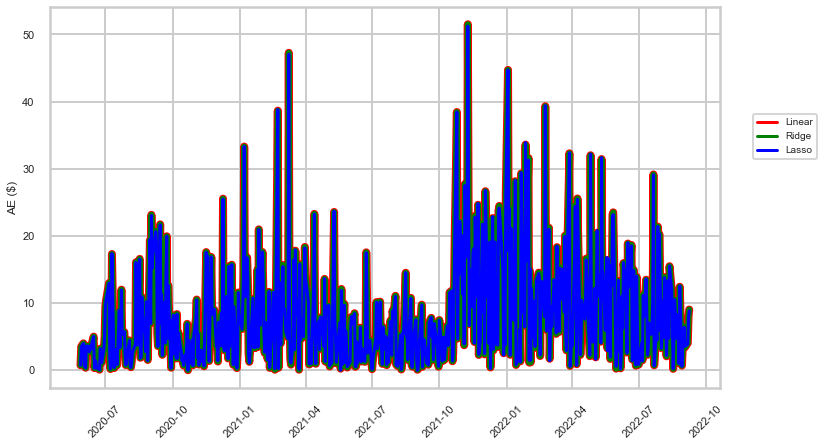

In [64]:
ae_rr = abs(y_test - pred_test_rr)
ae_lasso = abs(pred_test_lasso - y_test)
ae_linear = abs(y_pred - y_test)

#plot results
x = ae_rr.index
y = ae_linear
plt.plot(x,y,c='red', linewidth=8)
y = ae_rr
plt.plot(x, y, c='green', linewidth=6)
y = ae_lasso
plt.plot(x, y,c='blue', linewidth=3)
plt.ylabel('AE ($)')
# plt.xlabel('Time')
plt.xticks(rotation = 45)


#generate legend
line_1 = Line2D([0], [0], color='red', linewidth=3, linestyle='solid',label='Linear')
line_2 = Line2D([0], [0], color='green', linewidth=3, linestyle='solid',label='Ridge')
line_3 = Line2D([0], [0], color='blue', linewidth=3, linestyle='solid',label='Lasso')
lines = [line_1, line_2, line_3]
plt.legend(prop=dict(size='small'), loc=[1.05, 0.6],handles=lines)

Text(0.5, 1.0, 'Distribution plot of Error - Lasso Regression')

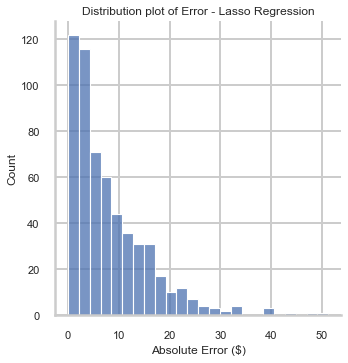

In [67]:
#check distributions just to be aware
sns.displot(ae_lasso)
plt.xlabel('Absolute Error ($)')
plt.title('Distribution plot of Error - Lasso Regression')